In [4]:
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pylab as plt

## Simple/Toy Models

## Interrupts

### Time

Let $\lambda$ = arrival rate in requests/sec. On average, the time between two requests is:

$\delta t = \frac{1}{\lambda}$

We will analyze this fundamental interval of length $\delta t$. This interval can be broken into 3 chunks:

* $t_1$ = itr = $\tau$ ("tau")

* $t_2$ = time spent processing = $t_{\text{busy}}$

* $t_3$ = time spend sleeping

In other words, the claim is:

$\delta t = \frac{1}{\lambda} = t_1 + t_2 + t_3 = \tau + t_{\text{busy}} + t_3$

Let's posit the dependence of these terms on DVFS, $\Delta$ ("Delta").

Claim: $t_{\text{busy}} = A \frac{N_i}{\Delta^{1+\alpha}}$

Here, A is a constant of proportionality. We don't really care about it at this stage. It's something that can be inferred from the data (by "fitting").

$N_i$ = total number of instructions

$\Delta$ = DVFS which we are using as a proxy for CPU frequency

Naively, we would assume time is inversely proportional to frequency ($\alpha = 0$). $\alpha$ here is introduced to measure deviations from this naive behavior. This is also a free parameter or a degree of freedom that is inferred from the data.

The last piece is $t_3$. This is the time remaining after waiting for $\tau$ (itr) and doing the processing. So, we would formally write this as:

$t_3 = \left[\frac{1}{\lambda} - t_{\text{busy}} - \tau \right]^{+}$

where $\left[x\right]^{+} = x$ if $x > 0$ and 0 otherwise. Read this as the positive part of $x$.

The two quantities we measure are latency and energy. Latency is:

$t_{\text{latency}} = \tau + t_{\text{busy}}$

We still need to discuss energy.

### Energy

The energy consumed in a certain time-period, t at a constant rate (power), P is simply E = Pt.

The total energy consumed in the fundamental time-interval, $\delta t$, is

$\text{E} = P_{\text{idle}} \tau + P_{\text{busy}} t_{\text{busy}} + P_{\text{sleep}} \left[\frac{1}{\lambda} - t_{\text{busy}} - \tau \right]^{+}$

Don't take the subscripts on the different power values too seriously. The point is that, potentially, each time-interval can consume energy at different rates.

We need to posit the DVFS dependence of the power values too. We know that CPU power, $\text{P} \propto V^2 f$ where V = voltage supplied and f = CPU frequency. DVFS affects both V and f and we are going to write this dependence as, $P_{\text{busy}} = B \Delta^{2+\beta}$. If the actual power goes as $\Delta^3$ for example, then $\beta = 1$. $\beta$ gives us another degree of freedom. For $P_{\text{idle}}$ and $P_{\text{sleep}}$, we will assume they are constants and not affected by DVFS. It is easy to put in DVFS dependence if we wanted to.

To simplify matters, assume that $t_3$ is positive.

$\delta t = \tau + t_{\text{busy}} + \left[\frac{1}{\lambda} - t_{\text{busy}} - \tau \right] = t_{\text{latency}} + \left[\frac{1}{\lambda} - t_{\text{busy}} - \tau \right]$


$\text{E} = P_{\text{idle}} \tau + P_{\text{busy}} t_{\text{busy}} + P_{\text{sleep}} \left[\frac{1}{\lambda} - t_{\text{busy}} - \tau \right]$




$$E = (P_\text{idle} - P_\text{sleep}) \tau + (P_\text{busy} - P_\text{sleep}) t_\text{busy} + \frac{P_\text{sleep}}{\lambda}$$

Inserting DVFS dependence:

$$E = (P_\text{idle} - P_\text{sleep}) \tau + (B\Delta^{2+\beta} - P_\text{sleep}) A\frac{N_i}{\Delta^{1+\alpha}} + \frac{P_\text{sleep}}{\lambda}$$

Note: If p_idle and p_sleep are not zero below, we will have to be careful to have the correct orders-of-magnitude for A, B and N.

In [ ]:
qps = 1 #queries per second
p_idle = 0 #in watts
p_sleep = 0 #in watts
A = B = 1
N = 1

def get_time_energy(itr, dvfs, alpha, beta): 
    t_busy = A*N / dvfs**(1+alpha)
    t_latency = itr + t_busy
    energy = (p_idle-p_sleep)*itr + A*N*(B*dvfs**(2+beta)-p_sleep)/(dvfs**(1+alpha)) + p_sleep/qps
    
    return t_latency, energy

In [ ]:
def make_plot(ax, itr=0, alpha=0, beta=0, dvfs=np.linspace(1,10,100)):    
    t_latency, energy = get_time_energy(itr, dvfs, alpha, beta)

    ax.plot(t_latency, energy, 'p')
    
    ax.set_xlabel("Latency")
    ax.set_ylabel("Energy")
    ax.set_title(f'alpha = {alpha}, beta = {beta}')

In [ ]:
alpha_range = np.arange(4)
beta_range = np.arange(4)

plt.rcParams['figure.figsize'] = (15.0, 12.0)
fig, ax_list = plt.subplots(nrows = len(alpha_range), ncols=len(beta_range))

for idx_alpha, alpha in enumerate(alpha_range):
    for idx_beta, beta in enumerate(beta_range):        
        make_plot(ax_list[idx_alpha, idx_beta], itr=4, alpha=alpha, beta=beta, dvfs=np.linspace(1, 10, 100))
        
plt.tight_layout()

## Exponential Distributions and busy time vs interarrival time

We will assume that both busy time and interarrival times are exponentially distributed. A random variable $T$ is exponentially distributed


$$T \sim Exp(\lambda)$$

if it has the p.d.f. (probability distribution function):

$$p(t) = \lambda \exp(-\lambda t)$$

You can think of $p(t)$ as the probability that a time measurement falls between $t$ and $t+dt$ where $dt$ is an infinitesimal element. The leading $\lambda$ ensures normalization i.e. that the probabilities to observe any time is 1:

$$\int_0^{\infty} dt p(t) = 1$$

Our question is: Given two exponentially distributed random variables:

$$T_1 \sim Exp(\lambda_1)$$

and

$$T_2 \sim Exp(\lambda_2)$$

what is the probability that a measurement of $T_2$ is greater than that of $T_1$?

Let's first calculate that $T_2$ exceeds $T_1$ by an amount $t > 0$:

$$\mathbb{P}[T_2 - T_1 = t] = \int_0^{\infty}\int_0^{\infty} dt_1 dt_2 p_1(t_1) p_2(t_2) \delta(t_2 - t_1 - t)$$

where $p_1$ is the pdf of $T_1$, $p_2$ is the pdf of $T_2$ and $\delta$ is the Dirac-delta function that enforces the constraint. Doing the $t_2$ integral, we get

$$\mathbb{P}[T_2 - T_1 = t] = \int_0^{\infty} dt_1 \lambda_1 \exp(-\lambda_1 t_1) \lambda_2 \exp(-\lambda_2(t_1 + t)) $$

$$\mathbb{P}[T_2 - T_1 = t] = \lambda_1 \lambda_2 \exp(-\lambda_2 t) \int_0^{\infty} dt_1 \exp(-(\lambda_1+\lambda_2)t_1) = \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} \exp(-\lambda_2 t)$$

Since we just care about $T_2 > T_1$, we need to integrate over all possible time-deltas $t$,

$$\mathbb{P}[T_2 > T_1] = \int_0^{\infty} dt \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} \exp(-\lambda_2 t) 
= \boxed{\frac{\lambda_1}{\lambda_1 + \lambda_2}}$$


Also, it can be easily shown that the mean-time: $\mathbb{E}[T_i] = \frac{1}{\lambda_i}$ and since we measure mean times in our measurements, we can replace this by:

$$\mathbb{P}[T_2 > T_1] = \boxed{\frac{\frac{1}{\mathbb{E}[T_1]}}{\frac{1}{\mathbb{E}[T_1]} + \frac{1}{\mathbb{E}[T_2]}}}$$

In our case,

$T_1 = \text{ref cycles per iteration converted to time}$

$T_2 = \text{inter-arrival time}$


## Mapping to Timeline Plot

$\boxed{\delta t = t_{\text{detect}} + t_{\text{osreq}} + t_{\text{app}} + t_{\text{idlepolicy}} + t_q} = t_{\text{detect}} + t_{\text{work}} + t_q = t_{\text{latency}} + t_q = \frac{1}{\lambda}$

$\boxed{E = P_\text{detect} t_{\text{detect}} + P_{\text{work}} \left[t_{\text{osreq}} + t_{\text{app}} + t_{\text{idlepolicy}}\right] + P_q t_q} = P_\text{detect} t_{\text{detect}} + P_{\text{work}} t_{\text{work}} + P_q t_q$

$\delta t = \frac{1}{\lambda}$ or equivalently, $t_q = \left[\frac{1}{\lambda} - t_\text{work} - t_{\text{detect}}\right]^+$ with $t_{\text{work}} \equiv t_{\text{osreq}} + t_{\text{app}} + t_{\text{idlepolicy}}$.

$t_{\text{work}} = A\frac{N_i}{\Delta^{1+\alpha}}$

$P_{\text{work}} = B \Delta^{2+\beta}$

switch busy -> work, osref -> osreq

In [ ]:
#parameters
qps = 40*1000 #queries per second
##alpha = 1
##beta = 1

p_detect = 10 #in watts
p_busy_min = 20
p_static = {
    'c1':4, 
    'c3':3,
    'c4':2,
    'c7':1,
    'busy': 10
}
chosen_sleep = 'c7'

##max_busy_frac = 0.2 #slowest dvfs
##itr_frac = 0.3
##dvfs = 1

#power inference
p_busy = p_static['busy'] + p_busy_min*dvfs**(2+beta)
p_q = p_static[chosen_sleep]
p_detect = p_static[chosen_sleep]

#time inference
itr = (1./qps) * itr_frac
busy_frac = max_busy_frac / dvfs**(1+alpha) #function of dvfs - dvfs in [1, \infty]
t_busy = (1./qps) * busy_frac
t_q = (1./qps)*(1 - itr_frac - busy_frac)

t_latency = itr + t_busy
energy = (p_detect * itr) + (p_busy * t_busy) + (p_q*t_q)

## FINAL

In [35]:
qps = 40*1000 #queries per second
p_busy_min = 20
p_static = {
    'c1':1.5, 
    'c3':0.5,
    'c4':0.25,
    'c7':0,
    'busy': 10
}
chosen_sleep = 'c7'

def get_time_energy(itr_frac, max_busy_frac, dvfs, alpha, beta):
    p_busy = p_static['busy'] + p_busy_min*dvfs**(2+beta)
    p_q = p_static[chosen_sleep]
    p_detect = p_static[chosen_sleep]

    #time inference
    itr = (1./qps) * itr_frac
    busy_frac = max_busy_frac / dvfs**(1+alpha) #function of dvfs - dvfs in [1, \infty]
    t_busy = (1./qps) * busy_frac
    t_q = (1./qps)*(1 - itr_frac - busy_frac)

    t_latency = itr + t_busy
    energy = (p_detect * itr) + (p_busy * t_busy) + (p_q*t_q)
    
    return t_latency, energy

t_latency, energy = get_time_energy(0.2, 0.3, 1, 1, 1)
print(t_latency, energy)

1.25e-05 0.000225


In [99]:
#plot energy vs latency and sweep itr, dvfs for each plot
def make_plot(ax, itr_frac, dvfs, max_busy_frac = 0.2, alpha = 0, beta = 0):
    t_latency, energy = get_time_energy(itr_frac, max_busy_frac, dvfs, alpha, beta)

    ax.plot(t_latency, energy, 'p', label=f'df={100*itr_frac:.0f}%, wf={100*max_busy_frac:.0f}%')
    
    if alpha==-1: #time insensitive:
        i = 'a'
    elif alpha==-0.97: #power insensitive
        i = 'b'
    else: #both sensitive
        i = 'c'
        
    desc = {
            'a': 'No time sensitivity, power sensitive',
            'b': 'Small time sensitivity, power sensitive',
            'c': 'Larger time sensitivity, power sensitive'
            }
    
    ax.set_xlabel("Latency")
    ax.set_ylabel("Energy")
    #ax.set_title(f'time exponent = {1+alpha}, power exponent = {2+beta} \n df=%time spent in detection \n wf=%time spent doing work')
    ax.set_title(f'({i}) {desc[i]} (alpha={alpha}, beta={beta}) \n df=%time spent in detection \n wf=%time spent doing work')
    ax.legend()

IndexError: index 3 is out of bounds for axis 0 with size 3

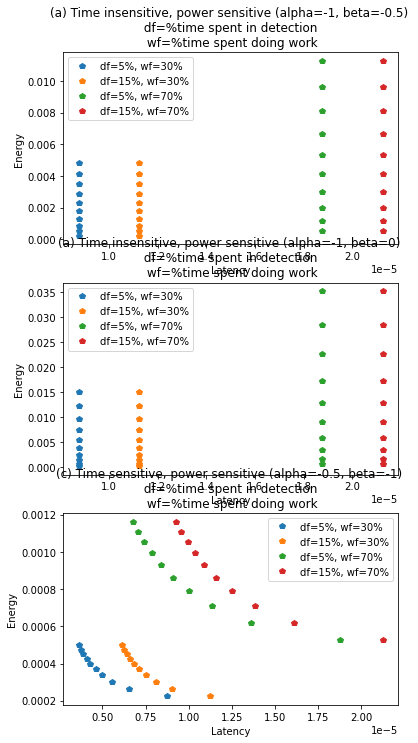

In [68]:
alpha_range = [-1, -0.5, -0.1] #, 0] #, 0, 0.5, 1, 2]
beta_range = [-1, -0.5, 0] #, 0, 0.5, 1, 2]

#plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams['figure.figsize'] = (6.0, 12.0)
#fig, ax_list = plt.subplots(nrows = len(alpha_range), ncols=len(beta_range))
fig, ax_list = plt.subplots(nrows = 3)

counter = 0
for idx_alpha, alpha in enumerate(alpha_range):
    for idx_beta, beta in enumerate(beta_range):
        if idx_alpha==0 and idx_beta==0:
            continue
        for itr_frac, max_busy_frac in [(0.05, 0.3), (0.15, 0.3), (0.05, 0.7), (0.15, 0.7)]:
            #make_plot(ax_list[idx_alpha, idx_beta], itr_frac=itr_frac, dvfs=np.arange(1, 11), max_busy_frac=max_busy_frac, alpha=alpha, beta=beta)        
            make_plot(ax_list[counter], itr_frac=itr_frac, dvfs=np.arange(1, 11), max_busy_frac=max_busy_frac, alpha=alpha, beta=beta)        
        counter += 1
plt.tight_layout()

plt.savefig('model_plots.png')

# Plot paper

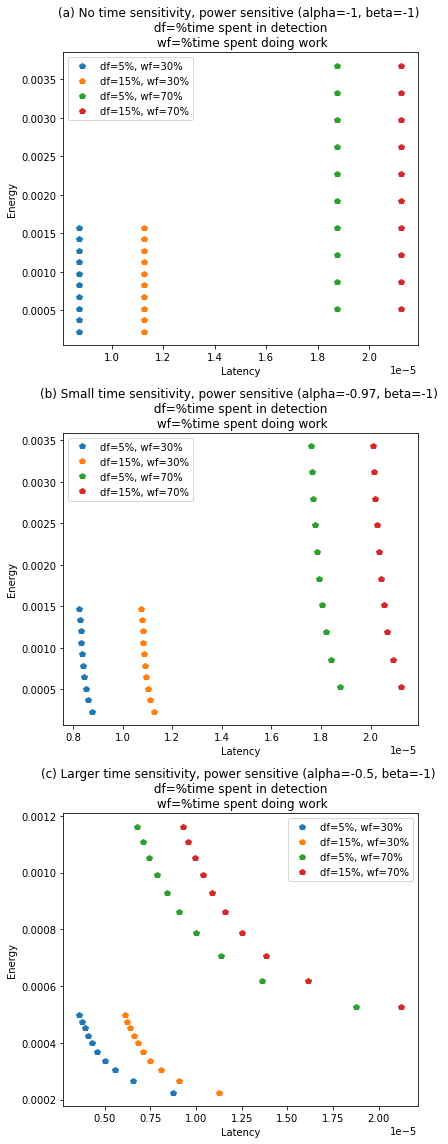

In [100]:
plt.rcParams['figure.figsize'] = (6.0, 16.0)
fig, ax_list = plt.subplots(nrows = 3)

counter = 0
#for alpha, beta in [(-1, -1), (-0.5, -1), (-0.25, -1), (-0.1,-1), (-0.05, -1), (0, -1)]:
for alpha, beta in [(-1, -1), (-0.97, -1), (-0.5, -1)]:
    for itr_frac, max_busy_frac in [(0.05, 0.3), (0.15, 0.3), (0.05, 0.7), (0.15, 0.7)]:
        make_plot(ax_list[counter], itr_frac=itr_frac, dvfs=np.arange(1, 11), max_busy_frac=max_busy_frac, alpha=alpha, beta=beta)        
    counter += 1
plt.tight_layout()

plt.savefig('model_plots.png')